In [1]:
import io
import json
import os
import sys
import pandas as pd
from bs4 import BeautifulSoup as bs
import requests
import numpy as np
from scipy import stats
import datetime
import time
import statistics as st
import requests_cache
import concurrent

from collections.abc import MutableMapping

In [22]:
headers = {
    'Accept-Encoding': 'gzip, deflate, sdch',
    'Accept-Language': 'en-US,en;q=0.8',
    'Upgrade-Insecure-Requests': '1',
    'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/56.0.2924.87 Safari/537.36',
    'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8',
    'Cache-Control': 'max-age=0',
    'Connection': 'keep-alive',
}

hippo_letrot = ["LE MONT-SAINT-MICHEL-PONTORSON", "BORDEAUX", "LE CROISE-LAROCHE"]
hippo_pmu =  ["LE MONT SAINT MICHEL", "LE BOUSCAT", "LE CROISE LAROCHE"]

requests_cache.install_cache('turf_cache')

In [29]:
def get_programme(debut, fin):
    programme = []
    url = f"https://www.letrot.com/fr/courses/calendrier-resultats?publish_up={debut}&publish_down={fin}"
    r = requests.get(url, headers=headers)
    soup = bs(r.text, "html.parser")
    reunion_raw = soup.find_all("a", {"class": "racesHippodrome"})
    
    current_date_reunion = "0"
    current_programme = {}
    
    
    for i in range(len(reunion_raw)):
        reunion = reunion_raw[i]
        date = reunion.get("href").split("/")[-2]
        hippodrome = reunion.text[2:].strip().replace(" (A ", " ").replace(")", "")
        for i in range(len(hippo_letrot)):
            hippodrome = hippodrome.replace(hippo_letrot[i], hippo_pmu[i])
        
        date_pmu = "".join(date.split("-")[::-1])
        
        if current_date_reunion != date_pmu:
            current_date_reunion = date_pmu
            current_programme = requests.get(f"https://online.turfinfo.api.pmu.fr/rest/client/65/programme/{date_pmu}/", headers=headers).json()
        numReunion = 0
#         print(hippodrome)
        for reunion_pmu in current_programme["programme"]["reunions"]:
            if hippodrome in reunion_pmu["hippodrome"]["libelleCourt"]:
                numReunion = reunion_pmu["numOfficiel"]
                break
        
        if numReunion == 0:
            continue
        course = {"date": date, "idHippo": reunion.get("href").split("/")[-1], "Hippodrome": hippodrome, "lien": reunion.get("href")}
        course["numReunion"] = numReunion
        programme.append(course)
    
    return pd.DataFrame(programme)

In [30]:
reu = get_programme("14-11-2022", "14-11-2022")
reu.head()

,date,idHippo,Hippodrome,lien,numReunion
0,2022-11-14,3302,LE BOUSCAT,/stats/courses/programme/2022-11-14/3302,1
1,2022-11-14,5901,LE CROISE LAROCHE,/stats/courses/programme/2022-11-14/5901,4
2,2022-11-14,1400,CAEN,/stats/courses/programme/2022-11-14/1400,6


In [14]:
def courses(reunions):
    courses_list = []  
    participants_list = []

    for i, row in reunions.iterrows():
        url = f"https://www.letrot.com/{row['lien']}/json"
        date_pmu = "".join(row["date"].split("-")[::-1])    
        r = requests.get(url, headers=headers)
        courses = r.json()
        for c in courses["course"]:
            if c["discipline"] == "Attelé":
                course_id = row["date"].replace("-", "") + str(row["idHippo"]) + str(c["numCourse"])
                courses_list.append({"date": row["date"], "id": course_id, "numReunion": row["numReunion"], "hippodrome": courses["nomHippodrome"], "idHippo": row["idHippo"],**c})
    return pd.DataFrame(courses_list)

In [15]:
courses_df = courses(reu)
courses_df.head()

,date,id,numReunion,hippodrome,idHippo,heureCourse,discipline,numCourse,prix,allocation,distance,categorie,typePiste,conditionsEngagement,hasTracking,hasVideoHeat,statut,classement,linkPrix,replay
0,2022-11-14,2022111433021,1,BORDEAUX,3302,11:55,Attelé,1,PRIX DINAROBIN BEACHCOMBER,6 000,2 650,Course G,,"CHALLENGE UNAT<br />Amateurs<br />Pour 7, 8 et...",False,False,0,,https://www.letrot.com/stats/fiche-course/2022...,
1,2022-11-14,2022111433022,1,BORDEAUX,3302,12:30,Attelé,2,PRIX SHANDRANI BEACHCOMBER,20 000,2 550,Course E,,Course E<br />Départ à l'autostart<br />Pour 3...,False,False,0,,https://www.letrot.com/stats/fiche-course/2022...,
2,2022-11-14,2022111433023,1,BORDEAUX,3302,13:05,Attelé,3,PRIX VICTORIA BEACHCOMBER,20 000,2 550,Course E,,"Départ à l'autostart<br />Pour 4 ans, n'ayant ...",False,False,0,,https://www.letrot.com/stats/fiche-course/2022...,
3,2022-11-14,2022111433024,1,BORDEAUX,3302,13:50,Attelé,4,PRIX BEACHCOMBER RESORTS & HOTELS,38 000,2 650,Course C,,Course C<br />Circuit des Grandes Epreuves du ...,False,False,0,,https://www.letrot.com/stats/fiche-course/2022...,
4,2022-11-14,2022111433026,1,BORDEAUX,3302,15:00,Attelé,6,PRIX PARADIS BEACHCOMBER,20 000,2 550,Course F,,Course F<br />Départ à l'autostart<br />Pour 5...,False,False,0,,https://www.letrot.com/stats/fiche-course/2022...,


In [76]:
courses_df.tail()

,date,id,hippodrome,idHippo,heureCourse,discipline,numCourse,prix,allocation,distance,categorie,typePiste,conditionsEngagement,hasTracking,hasVideoHeat,statut,classement,linkPrix,replay
9,2022-11-07,2022110714004,CAEN,1400,14:30,Attelé,4,PRIX DE CEAUCE (Gr B),12 000,2 450,Course G,,"Pour pouliches de 3 ans, ayant couru mais n'ay...",False,False,16,15 - 9 - 11 - 16 - 4,https://www.letrot.com/stats/fiche-course/2022...,"<a href=""https://www.letrot.com/fr/replay-cour..."
10,2022-11-07,2022110714005,CAEN,1400,15:00,Attelé,5,PRIX DE MEUVAINES (Gr A),12 000,2 450,Course G,,"Pour pouliches de 4 ans, n'ayant pas gagné 13....",False,False,16,16 - 11 - 8 - 3 - 13,https://www.letrot.com/stats/fiche-course/2022...,"<a href=""https://www.letrot.com/fr/replay-cour..."
11,2022-11-07,2022110714006,CAEN,1400,15:29,Attelé,6,PRIX DE MEUVAINES (Gr B),12 000,2 450,Course G,,"Pour pouliches de 4 ans, n'ayant pas gagné 13....",False,False,16,3 - 12 - 7 - 8 - 9,https://www.letrot.com/stats/fiche-course/2022...,"<a href=""https://www.letrot.com/fr/replay-cour..."
12,2022-11-07,2022110714007,CAEN,1400,15:57,Attelé,7,PRIX DE MISSY (Gr A),12 000,2 450,Course G,,"Pour poulains entiers et hongres de 4 ans, n'a...",False,False,16,7 - 11 - 3 - 8 - 14,https://www.letrot.com/stats/fiche-course/2022...,"<a href=""https://www.letrot.com/fr/replay-cour..."
13,2022-11-07,2022110714008,CAEN,1400,16:25,Attelé,8,PRIX DE MISSY (Gr B),12 000,2 450,Course G,,"Pour poulains entiers et hongres de 4 ans, n'a...",False,False,16,5 - 13 - 12 - 10 - 7,https://www.letrot.com/stats/fiche-course/2022...,"<a href=""https://www.letrot.com/fr/replay-cour..."


In [79]:
participants_df

,nom,numPmu,age,sexe,race,statut,oeilleres,proprietaire,entraineur,driver,...,dernierRapportReference_grossePrise,commentaireApresCourse_texte,commentaireApresCourse_source,deferre,incident,id,numReunion,placeCorde,ecurie,poidsConditionMonte
0,HISTOIRE THORIS,1,5,FEMELLES,TROTTEUR FRANCAIS,PARTANT,SANS_OEILLERES,Ec. Arnaud RANDON,A. RANDON,A. RANDON,...,False,"Vite en queue de peloton, n'a pas été menaçante.",GENY,NaN,NaN,2022110775001,1,NaN,NaN,NaN
1,HIRONDELLE FEE,2,5,FEMELLES,TROTTEUR FRANCAIS,PARTANT,SANS_OEILLERES,Thomas VIDARD,G. DELACOUR,G. DELACOUR,...,False,"Vite en queue de peloton, n'a pas été menaçant...",GENY,NaN,NaN,2022110775001,1,NaN,NaN,NaN
2,HOLDING GIRL,3,5,FEMELLES,TROTTEUR FRANCAIS,PARTANT,SANS_OEILLERES,Y. DREUX,Y. DREUX,E. RAFFIN,...,False,"Relayée en plaine par Haïtian Fight Song, a ét...",GENY,DEFERRE_ANTERIEURS_POSTERIEURS,NaN,2022110775001,1,NaN,NaN,NaN
3,HISA DU MARGAS,4,5,FEMELLES,TROTTEUR FRANCAIS,PARTANT,SANS_OEILLERES,Ecurie J.Y. et J.P. RAFFEGEAU,J.PH. RAFFEGEAU,D. THOMAIN,...,False,"Progressivement reléguée en queue de peloton, ...",GENY,DEFERRE_ANTERIEURS_POSTERIEURS,NaN,2022110775001,1,NaN,NaN,NaN
4,HIGHNESS KALOUMA,5,5,FEMELLES,TROTTEUR FRANCAIS,PARTANT,SANS_OEILLERES,Ecurie Ph. BOFF,R. DERIEUX,R. DERIEUX,...,False,"Longtemps dans le dernier tiers du peloton, a ...",GENY,DEFERRE_ANTERIEURS_POSTERIEURS,NaN,2022110775001,1,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215,IROKO DEL SOL,12,4,HONGRES,TROTTEUR FRANCAIS,PARTANT,SANS_OEILLERES,G. SIMON,G. SIMON,G. SIMON,...,False,NaN,NaN,DEFERRE_POSTERIEURS,NaN,2022110714008,8,NaN,NaN,NaN
216,IMOYO WOLF,13,4,MALES,TROTTEUR FRANCAIS,PARTANT,SANS_OEILLERES,Y. SALIOT,Y. SALIOT,Y. SALIOT,...,NaN,NaN,NaN,DEFERRE_ANTERIEURS_POSTERIEURS,NaN,2022110714008,8,NaN,NaN,NaN
217,IPIK DE BELFOND,14,4,HONGRES,TROTTEUR FRANCAIS,PARTANT,SANS_OEILLERES,J.M. GILLER,E. VARIN,J.B. LELIEVRE,...,False,NaN,NaN,NaN,DISQUALIFIE_POUR_ALLURE_IRREGULIERE,2022110714008,8,NaN,NaN,NaN
218,INVICTUS D'AVENIR,15,4,HONGRES,TROTTEUR FRANCAIS,PARTANT,SANS_OEILLERES,M. VARIN,M. VARIN,R. LAMY,...,NaN,NaN,NaN,DEFERRE_POSTERIEURS,NaN,2022110714008,8,NaN,NaN,NaN


In [16]:
def info_tableau_partant(courseId, date, idHippo, numCourse, numReunion, classement):
    chevaux = []
    url = f"https://www.letrot.com/stats/fiche-course/{date}/{idHippo}/{numCourse}/partants/tableau"
    r = requests.get(url, headers=headers)
    soup = bs(r.text, "html.parser")
    headers_table = soup.find("table", {"id": "result_table"}).find("thead").find("tr").find_all("th")
    table = soup.find("table", {"id": "result_table"}).find("tbody")
    rows = table.find_all("tr")
    
    url_arrivee = f"https://www.letrot.com/stats/fiche-course/{date}/{idHippo}/{numCourse}/resultats/arrivee-definitive"
    r_arrivee = requests.get(url_arrivee, headers=headers)
    soup_arrivee = bs(r_arrivee.text, "html.parser")
    table_arrivee = soup_arrivee.find("table", {"id": "result_table"}).find("tbody")
    rows_arrivee = table_arrivee.find_all("tr")
    
    classement = {row.select("td")[1].text : row.select("td")[0].find("span", {"class": "bold"}).text for row in rows_arrivee}
    
    
    date_pmu = "".join(date.split("-")[::-1])  
    participants_pmu = requests.get(f"https://online.turfinfo.api.pmu.fr/rest/client/65/programme/{date_pmu}/R{numReunion}/C{numCourse}/participants", headers=headers)
    try:
        participants = participants_pmu.json()["participants"]
    except:
        raise Exception("probleme api pmu")
    participants = pd.json_normalize(participants, sep="_").to_dict(orient="records")
    participants_with_id = [dict(item, **{"id": courseId, "numReunion": numReunion}) for item in participants]    
    participants_pmu_df = pd.DataFrame(participants_with_id)
    
#     print(classement)
    
    for i,row in enumerate(rows):
            num = row.select("td")[0].find("span", {"class": "bold"}).text
            col = row.select("td")
            cheval = {}
            cheval["num"] = num
            cheval["nom"] = col[1].text
#             print(classement)
#             cheval["classement"] = classement[num]
            cheval["id"] = courseId
            cheval["date"] = date
            cheval["url"] = col[1].find("a").get("href")
            
            cheval["numCoursePMU"] = f"R{numReunion}C{numCourse}"
            
            cheval.update(info_cheval(cheval["url"], date))

            cheval["fer"] = int(col[3].text) if col[3].text else 0
            cheval["firstTimeFer"] = True if col[3].find("div", {"class", "fer-first-time"}) else False
            cheval["sex"] = 0 if col[4].text == "M" else 1
            cheval["age"] = int(col[5].text)
            cheval["dist"] = int(col[6].text.replace(" ", "").replace("\n", ""))
            cheval["driver"] = col[7].find("a").get("href")
            cheval["trainer"] = col[8].find("a").get("href")

            if "Avis" in headers_table[9].text:
                cheval["avisTrainer"] = int(col[9].get("data-order"))
                avis = col.pop(9)
                col.insert(-1, avis)
            else:
                cheval["avisTrainer"] =2

            cheval["music"] = list(filter(lambda x: "a" in x, col[9].text.replace("D", "0").replace("Ret", "0").replace("T", "0").split()))
            cheval["music"] = list(map(lambda x: x[0], cheval["music"]))

            cheval["music"] = list(filter(lambda x: x.isnumeric(), cheval["music"]))

            cheval["music"] = list(map(int, cheval["music"]))
            
            if len(cheval["music"]) < 4:
                raise ValueError("not enough data")
            
            cheval["nbArrivé"] = len(cheval["music"]) - cheval["music"].count("0")
            cheval["lastPerf"] = cheval["music"][0] if cheval["nbArrivé"] else 0

            arriveOnly = list(filter(None, cheval["music"]))
            if len(arriveOnly) > 0:
                try:
                    cheval["meanPerf"] = np.mean(arriveOnly)
                    cheval["medianPerf"] = np.median(arriveOnly)
                    cheval["modePerf"] = st.mode(cheval["music"])
                except:
                    cheval["meanPerf"] = 0
                    cheval["medianPerf"] = 0
                    cheval["modePerf"] = 0
            else:
                cheval["meanPerf"] = 0
                cheval["medianPerf"] = 0
                cheval["modePerf"] = 0

            try:
                cheval["recordAbs"] = list(map(int, col[10].text.replace(col[10].span.text, "").replace("\'", '"').split('"')))
                cheval["recordAbs"] = cheval["recordAbs"][0] * 10 * 60 + cheval["recordAbs"][1] * 10 + cheval["recordAbs"][2]
            except:
                cheval["recordAbs"] = None

            cheval["gain"] = int(col[11].find("div", class_="gains").text.replace(" ", "")[:-1])

            chevaux.append(cheval)
    combined = pd.merge(pd.DataFrame(chevaux), participants_pmu_df, how="left", left_on = ["id", "nom"], right_on = ["id", "nom"])
    return combined

In [17]:
def info_couple(courseId, date, idHippo, numCourse):
    couple_info = []
    date_splitted_arrive = "%2F".join(date.split("-")[::-1])
    date_splitted_depart = date.split("-")[::-1]
    date_splitted_depart[2] = str(int(date_splitted_depart[2]) - 1)
    date_splitted_depart = "%2F".join(date_splitted_depart)
    
    url = f"https://www.letrot.com/stats/fiche-course/{date}/{idHippo}/{numCourse}/partants/couples/paginate?datepicker_du={date_splitted_depart}&datepicker_au={date_splitted_arrive}"
    r = requests.get(url, headers=headers)
    dic_json = r.json()
    data = dic_json["data"]

    data_sorted = sorted(data, key=lambda x: x["numero"])
    for couple in data_sorted:
        cheval = {}
        
        cheval["nbCourseCouple"] = bs(couple["nbre_courses"], "html.parser").find("div").text
        cheval["nbVictoiresCouple"] = bs(couple["nbre_victoires"], "html.parser").find("div").text
        cheval["nb2emeCouple"] = bs(couple["nbre_2eme"], "html.parser").find("div").text
        cheval["nb3emeCouple"] = bs(couple["nbre_3eme"], "html.parser").find("div").text
        cheval["txReussiteCouple"] = couple["taux_reussite_sort"]
        cheval["nonPartant"] = couple["nonPartant"]
        couple_info.append(cheval)
    return pd.DataFrame(couple_info)

In [18]:
def info_cheval(url, date):
    r = requests.get(url + "-paginate-2", headers=headers)
    date_debut = datetime.date.fromisoformat(date)
    jsoned = r.json()["data"]

    info_dict = {}

    for c in jsoned:
        c["dateCourse"] = datetime.date.fromisoformat(c["dateCourseRaw"])
    
    filtered = list(filter(lambda x: x["dateCourse"] < date_debut and x["specialite"] == "A", jsoned))
    
    info_dict["tpsLastRace"] = (date_debut - filtered[0]["dateCourse"]).days
    
    info_dict["last_race_dist"] = int(filtered[0]["distance"].replace(" ", ""))

    return info_dict

In [19]:
def partants(course):
    partants = None
    for i, course in course.iterrows():
        url = f"https://www.letrot.com/stats/fiche-course/{course['date']}/{course['idHippo']}/{course['numCourse']}"
        url_tableau_partant = url + "/partants/tableau"
        url_cheval = url + "/partants/chevaux"
        
        try:
            dict_tableau_partant = info_tableau_partant(course['id'],course['date'], course['idHippo'],course['numCourse'], course["numReunion"], course["classement"])
        except:
            continue
        dict_couple = info_couple(course['id'],course['date'], course['idHippo'],course['numCourse'])
        
#         combined = dict_tableau_partant.join(dict_couple)
        
        combined = pd.concat([dict_tableau_partant, dict_couple], axis=1)
        
#         combined = combined.join(participants)

#         combined.to_csv("data.csv", mode='a', header=not os.path.exists("data.csv"))
        
#         combined = pd.merge(combined, participants_df, how="left", left_on = ["id", "nom"], right_on = ["id", "nom"])
    
        if not isinstance(partants, pd.DataFrame):
            partants = combined
        else:
            partants = pd.concat([partants, combined])
        
    return pd.DataFrame(partants)

In [163]:
url = "https://www.letrot.com/stats/fiche-cheval/grizman/ZWR8ZwoIAwQF/courses/dernieres-performances-paginate-2"
r = requests.get(url, headers=headers)
rjson = r.json()["data"]
rjson[0]["dateCourse"]
table.find("thead").find("tr").find_all("th")[9]
list(filter(lambda x: "a" in x, table.find("tbody").find_all("tr")[9].select("td")[9].text.replace("D", "0").split()))

AttributeError: 'str' object has no attribute 'span'

In [20]:
today = partants(courses_df)
today.head()

,num,nom,id,date,url,numCoursePMU,tpsLastRace,last_race_dist,fer,firstTimeFer,...,numReunion,nbCourseCouple,nbVictoiresCouple,nb2emeCouple,nb3emeCouple,txReussiteCouple,nonPartant,placeCorde,ecurie,poidsConditionMonte
0,1,FORTUNA MARINE,2022111433021,2022-11-14,https://www.letrot.com/stats/fiche-cheval/fort...,R1C1,72,2800,3,False,...,1,7,0,0,0,0,False,NaN,NaN,NaN
1,2,FLEUR DE PENGUEN,2022111433021,2022-11-14,https://www.letrot.com/stats/fiche-cheval/fleu...,R1C1,8,2725,2,False,...,1,12,0,1,2,25,False,NaN,NaN,NaN
2,3,FOX DU RIB,2022111433021,2022-11-14,https://www.letrot.com/stats/fiche-cheval/fox-...,R1C1,14,2725,3,False,...,1,10,2,2,2,60,False,NaN,NaN,NaN
3,4,FIRST KEN BLUE,2022111433021,2022-11-14,https://www.letrot.com/stats/fiche-cheval/firs...,R1C1,14,2725,2,False,...,1,15,4,0,1,33,False,NaN,NaN,NaN
4,5,ELLE LIMOUSINE,2022111433021,2022-11-14,https://www.letrot.com/stats/fiche-cheval/elle...,R1C1,29,2650,3,False,...,1,9,0,0,1,11,False,NaN,NaN,NaN


In [12]:
vincenne = partants(courses_df.loc[courses_df["idHippo"] == "7500"])

In [13]:
vincenne.to_csv("vincenne.csv")

In [21]:
today.to_csv("today.csv")

In [152]:
res2.to_csv("sqofuzarpoi.csv")

In [38]:
df = pd.read_csv("data.csv", index_col=0)
df["id"] = df["id"].astype("str")
df["music"]

0        [3, 3, 4, 1, 2, 1, 0, 0, 0, 5, 2]
1        [2, 1, 1, 3, 2, 6, 8, 0, 0, 0, 0]
2     [3, 4, 0, 1, 3, 2, 9, 7, 2, 4, 9, 3]
3        [0, 3, 1, 0, 5, 0, 1, 5, 0, 9, 0]
4        [0, 1, 7, 0, 0, 7, 5, 5, 1, 1, 2]
                      ...                 
11    [4, 0, 8, 3, 3, 1, 5, 4, 0, 3, 6, 3]
12       [0, 0, 4, 4, 0, 2, 7, 0, 0, 0, 0]
13       [9, 1, 6, 1, 0, 6, 0, 9, 2, 2, 1]
14       [0, 4, 5, 9, 6, 4, 0, 0, 2, 0, 9]
15    [0, 5, 2, 4, 3, 1, 0, 0, 0, 0, 7, 9]
Name: music, Length: 6277, dtype: object

In [96]:
res["classement"]

0       0
1       0
2       9
3       5
4       2
     ... 
11      5
12      0
13     DA
14      1
15    NaN
Name: classement, Length: 76, dtype: object

In [101]:
res["win"] = res["classement"] == "1"

In [102]:
res["win"].sum()

5

In [159]:
datetime.date.fromisoformat("2020-10-30") < datetime.date(2021,11,2)

True

In [170]:
(datetime.date.fromisoformat("2020-10-30") - datetime.date(2021,11,2)).days

-368

In [194]:
res.to_csv("test2.csv")

In [108]:
winner = res[res["win"] == True]

In [110]:
winner["dernierRapportDirect_rapport"]

11     3.0
15    84.0
9      1.8
10     4.8
14     2.5
Name: dernierRapportDirect_rapport, dtype: float64

In [106]:
plt.scatter(winner["dernierRapportDirect_rapport"])

KeyError: 'dernierRapportDirect_rapport'

# Prediction

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from statsmodels.discrete.conditional_models import ConditionalMNLogit,ConditionalLogit
import pylogit as pl
import matplotlib.pyplot as plt

from collections import OrderedDict

In [13]:
df = pd.read_csv("data.csv", index_col=0)
df = df.dropna()
df["win"] = df["classement"] == "1"
df.tail()

,num,nom,classement,id,date,url,fer,firstTimeFer,sex,age,...,modePerf,recordAbs,gain,nbCourseCouple,nbVictoiresCouple,nb2emeCouple,nb3emeCouple,txReussiteCouple,nonPartant,win
5,6.0,DIKTAT DU VIVIER,A,2.022073e+12,2022-07-29,https://www.letrot.com/stats/fiche-cheval/dikt...,3.0,False,1.0,9.0,...,7.0,730.0,188780.0,1,0,0,0,0,False,False
6,7.0,DAVY DE TAZIERE,7,2.022073e+12,2022-07-29,https://www.letrot.com/stats/fiche-cheval/davy...,3.0,False,1.0,9.0,...,0.0,730.0,197530.0,1,0,0,0,0,False,False
7,8.0,DAMOUR JIEL,2,2.022073e+12,2022-07-29,https://www.letrot.com/stats/fiche-cheval/damo...,3.0,False,0.0,9.0,...,8.0,725.0,200630.0,5,0,1,2,60,False,False
8,9.0,CHRISTMAS DU CEBE,DA,2.022073e+12,2022-07-29,https://www.letrot.com/stats/fiche-cheval/chri...,3.0,False,1.0,10.0,...,5.0,732.0,246560.0,18,1,0,0,5,False,False
9,10.0,DORUCK,6,2.022073e+12,2022-07-29,https://www.letrot.com/stats/fiche-cheval/doru...,4.0,False,1.0,9.0,...,2.0,727.0,318070.0,7,0,1,1,28,False,False


In [33]:
nums = df["fer"].unique()
count = [df.loc[df["fer"] == i]["win"].sum() / len(df.loc[df["fer"] == i]) for i in nums]

In [48]:
len(df["id"])

45266

<BarContainer object of 9 artists>

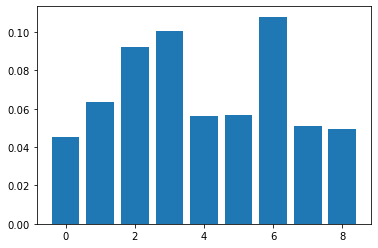

In [34]:
plt.bar(nums, count)

In [45]:
df.groupby("id")[["recordAbs", "win"]].min()

,recordAbs,win
id,,
2.022010e+12,732.0,False
2.022010e+12,720.0,False
2.022010e+12,705.0,False
2.022010e+12,712.0,False
2.022010e+12,717.0,False
...,...,...
2.022031e+13,724.0,False
2.022050e+13,709.0,False
2.022052e+13,728.0,False


In [14]:
list(df)

['num',
 'nom',
 'classement',
 'id',
 'date',
 'url',
 'fer',
 'firstTimeFer',
 'sex',
 'age',
 'dist',
 'driver',
 'trainer',
 'avisTrainer',
 'music',
 'nbArrivé',
 'lastPerf',
 'meanPerf',
 'medianPerf',
 'modePerf',
 'recordAbs',
 'gain',
 'nbCourseCouple',
 'nbVictoiresCouple',
 'nb2emeCouple',
 'nb3emeCouple',
 'txReussiteCouple',
 'nonPartant',
 'win']

In [48]:
features = ['id', 'num','fer','firstTimeFer','sex','age','avisTrainer','nbArrivé','lastPerf','meanPerf',
 'medianPerf',
 'modePerf',
 'recordAbs',
 'gain',
 'nbCourseCouple',
 'nbVictoiresCouple',
 'nb2emeCouple',
 'nb3emeCouple',
 'txReussiteCouple','win']

parametres = ['fer','firstTimeFer','sex','age','avisTrainer','nbArrivé','lastPerf','meanPerf',
 'medianPerf',
 'modePerf',
 'recordAbs',
 'gain',
 'nbCourseCouple',
 'nbVictoiresCouple',
 'nb2emeCouple',
 'nb3emeCouple',
 'txReussiteCouple']

In [53]:
[i for i in range(1,18)]

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]

In [70]:
# The 'alt_id_column' is the name of a column to be created in the long-format data
# It will identify the alternative associated with each row.
alt_id_column = "num"

# The "obs_id_column" is a custom id column that ignores the fact that this is a 
# panel/repeated-observations dataset. This column denotes each individual choice
# situation.
obs_id_column = "id"

# The "choice_column" records the name of the column that denotes whether or not each
# individual chose the alternative on a given row.
choice_column = "win"

basic_specification = OrderedDict()
basic_names = OrderedDict()

basic_specification["intercept"] = [1, 2]
basic_names["intercept"] = ['fer','nouveau_fer']

basic_specification["lastPerf"] = "all_diff"
basic_names["lastPerf"] = ['fer','firstTimeFer','sex','age','avisTrainer','nbArrivé','lastPerf','meanPerf',
 'medianPerf',
 'modePerf',
 'recordAbs',
 'gain',
 'nbCourseCouple',
 'nbVictoiresCouple',
 'nb2emeCouple',
 'nb3emeCouple',
 'txReussiteCouple', "test"]

basic_specification["gain"] = "all_diff"
basic_names["gain"] = ['fer','firstTimeFer','sex','age','avisTrainer','nbArrivé','lastPerf','meanPerf',
 'medianPerf',
 'modePerf',
 'recordAbs',
 'gain',
 'nbCourseCouple',
 'nbVictoiresCouple',
 'nb2emeCouple',
 'nb3emeCouple',
 'txReussiteCouple', "test"]


In [72]:
pl_model = pl.create_choice_model(data=df[features].astype(int),alt_id_col=alt_id_column, obs_id_col=obs_id_column, choice_col="win", specification=basic_specification,model_type="MNL",names=basic_names)

pl_model.fit_mle(np.zeros(38))

Log-likelihood at zero: -38,271.5120
Initial Log-likelihood: -38,271.5120


C:\Users\raves\anaconda3\lib\site-packages\scipy\optimize\_minimize.py:524: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  warn('Method %s does not use Hessian information (hess).' % method,


Estimation Time for Point Estimation: 0.59 seconds.
Final log-likelihood: -38,271.5120


In [73]:
prediction = pl_model.predict(df[features].iloc[-10:],choice_col=choice_column)

ValueError: names[lastPerf] should be a list with 10 elements, 1 element for each possible alternative

In [37]:
prediction

(array([0.1]), array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]))

In [74]:
pl_model.get_statsmodels_summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Multinomial Logit Model Regression Results                    
===================================================================================
Dep. Variable:                         win   No. Observations:                    1
Model:             Multinomial Logit Model   Df Residuals:                      -37
Method:                                MLE   Df Model:                           38
Date:                     Mon, 07 Nov 2022   Pseudo R-squ.:                   0.000
Time:                             21:24:53   Pseudo R-bar-squ.:              -0.001
AIC:                            76,619.024   Log-Likelihood:            -38,271.512
BIC:                            76,543.024   LL-Null:                   -38,271.512
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
fer                        0      5.949          0      1.000     -11.661      11.661
nouveau_fer                0      6.184          0      1.000     -12.120      12.120
fer                        0      1.176          0      1.000      -2.304       2.304
firstTimeFer               0      1.185          0      1.000      -2.322       2.322
sex                        0      0.913          0      1.000      -1.789       1.789
age                        0      0.929          0      1.000      -1.820       1.820
avisTrainer                0      0.940          0      1.000      -1.843       1.843
nbArrivé                   0      0.947          0      1.000      -1.857       1.857
lastPerf                   0      0.941          0      1.000      -1.844       1.844
meanPerf                   0      0.940          0      1.000      -1.841       1.841
medianPerf                 0      0.945          0      1.000      -1.852       1.852
modePerf                   0      0.998          0      1.000      -1.955       1.955
recordAbs                  0      1.044          0      1.000      -2.045       2.045
gain                       0      1.131          0      1.000      -2.216       2.216
nbCourseCouple             0      1.312          0      1.000      -2.571       2.571
nbVictoiresCouple          0      1.394          0      1.000      -2.733       2.733
nb2emeCouple               0      1.784          0      1.000      -3.497       3.497
nb3emeCouple               0      2.069          0      1.000      -4.056       4.056
txReussiteCouple           0      4.607          0      1.000      -9.030       9.030
test                       0      5.344          0      1.000     -10.474      10.474
fer                        0   4.16e-05          0      1.000   -8.15e-05    8.15e-05
firstTimeFer               0   4.61e-05          0      1.000   -9.04e-05    9.04e-05
sex                        0   4.07e-05          0      1.000   -7.97e-05    7.97e-05
age                        0   3.55e-05          0      1.000   -6.97e-05    6.97e-05
avisTrainer                0   3.73e-05          0      1.000   -7.31e-05    7.31e-05
nbArrivé                   0   3.87e-05          0      1.000   -7.58e-05    7.58e-05
lastPerf                   0   3.77e-05          0      1.000    -7.4e-05     7.4e-05
meanPerf                   0   3.32e-05          0      1.000   -6.51e-05    6.51e-05
medianPerf                 0   3.22e-05          0      1.000   -6.31e-05    6.31e-05
modePerf                   0   3.77e-05          0      1.000    -7.4e-05     7.4e-05
recordAbs                  0   3.74e-05          0      1.000   -7.32e-05    7.32e-05
gain                       0   4.21e-05          0      1.000   -8.25e-05    8.25e-05
nbCourseCouple             0   4.27e-05          0      1.000   -8.38e-05    8.38e-05
nbVictoiresCouple          0   4.18e-05          0      1.000   -8.19e-05    8.19e-05
nb2emeCouple  

In [129]:
X = df[['fer','firstTimeFer','sex','age','dist','avisTrainer','nbArrivé','lastPerf',
 'meanPerf',
 'medianPerf',
 'modePerf',
 'recordAbs',
 'gain',
 'nbCourseCouple',
 'nbVictoiresCouple',
 'nb2emeCouple',
 'nb3emeCouple',
 'txReussiteCouple',
 'nonPartant']].astype("int64")

scaler = preprocessing.StandardScaler().fit(X)

y = df[["win"]].astype("int64")

In [123]:
print(X.shape, y.shape)

(200, 19) (200, 1)


In [143]:
X[

,fer,firstTimeFer,sex,age,dist,avisTrainer,nbArrivé,lastPerf,meanPerf,medianPerf,modePerf,recordAbs,gain,nbCourseCouple,nbVictoiresCouple,nb2emeCouple,nb3emeCouple,txReussiteCouple,nonPartant
0,3,0,1,6,2400,1,11,5,4,5,1,719,78820,7,4,1,0,71,0
1,3,0,1,6,2400,2,12,5,5,5,5,728,79970,1,0,0,0,0,0
2,3,0,1,6,2400,1,12,3,4,4,3,737,77690,5,2,1,1,80,0
3,6,0,1,6,2400,2,12,3,4,4,0,725,78110,3,0,0,0,0,0
4,0,0,1,6,2400,2,12,9,4,4,2,729,79860,4,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1985,3,0,0,5,2700,2,12,4,4,3,3,712,105720,5,0,0,2,40,0
1986,3,0,1,5,2700,2,11,0,4,4,0,720,105830,2,0,0,0,0,0
1987,3,0,1,5,2700,2,11,9,4,2,1,733,106320,4,2,0,0,50,0
1988,0,0,1,5,2700,3,11,0,5,5,0,722,107280,1,0,0,0,0,0


In [130]:
scaler = preprocessing.StandardScaler().fit(X)

In [76]:
scaler.transform(X[-16:])

array([[-0.97996827, -0.20892772,  0.33222574, -0.05980558,  0.21824127,
         2.37601827,  0.42285933, -1.09844009, -0.19734967, -0.83638939,
        -0.73478855, -0.28743235,  0.27404864,  1.59279573,  1.57010624,
         1.94126998,  0.75723553,  0.4769169 , -0.1047997 ],
       [ 0.61518786, -0.20892772,  0.33222574, -0.05980558,  0.21824127,
        -0.007769  ,  0.76977734,  0.52636162, -0.19734967,  0.31485761,
         1.1117112 , -1.40797057,  0.32509605,  0.01530122,  0.53776139,
        -0.55794543,  0.75723553,  0.444908  , -0.1047997 ],
       [ 0.08346915, -0.20892772,  0.33222574, -0.05980558,  0.21824127,
        -2.39155626,  0.07594131, -1.09844009, -0.89874108, -0.83638939,
        -0.73478855, -0.78046917,  0.32745208, -0.66076786, -0.49458347,
        -0.55794543, -0.58450712, -0.83544783, -0.1047997 ],
       [ 0.61518786, -0.20892772, -3.01000154, -0.05980558,  0.21824127,
        -2.39155626,  0.42285933,  1.1762823 , -0.89874108, -0.83638939,
        -0.734

### Conditionnal Logit

In [145]:
model = ConditionalLogit(endog=y, exog=scaler.transform(X), groups=df["id"])
model.fit(method="lbfgs", maxiter=1000, full_output=True)

C:\Users\raves\anaconda3\lib\site-packages\statsmodels\discrete\conditional_models.py:80: UserWarning: Dropped 6 groups and 42 observations for having no within-group variance
  warnings.warn(msg)


In [144]:
model.score(X.iloc[0])

C:\Users\raves\anaconda3\lib\site-packages\statsmodels\discrete\conditional_models.py:296: RuntimeWarning: overflow encountered in exp
  exb = np.exp(np.dot(ex, params) + ofs)
C:\Users\raves\anaconda3\lib\site-packages\statsmodels\discrete\conditional_models.py:319: RuntimeWarning: invalid value encountered in double_scalars
  u, v = a + c * h, b + d + e * h
C:\Users\raves\anaconda3\lib\site-packages\statsmodels\discrete\conditional_models.py:348: RuntimeWarning: invalid value encountered in true_divide
  return self._xy[grp] - h / d


array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan])

In [78]:
pip install pylogit

Note: you may need to restart the kernel to use updated packages.


In [302]:
pipe = make_pipeline(preprocessing.StandardScaler(), LogisticRegression())
pipe.fit(X[:1500],y[:1500])
#clf = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000).fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

In [280]:
print(X[2], y[2])

[    3     0     1     6  2400     1    12     3     4     4     3   737
 77690     5     2     1     1    80     0] 1


In [301]:
pipe.predict_proba([X[9]])

array([[0.23910339, 0.26968631, 0.38287318, 0.05802779, 0.05030933]])

In [293]:
pipe.classes_

array([0, 1, 2, 3, 4], dtype=int64)

In [304]:
res2.tail(10)

,classement,nom,id,date,url,fer,firstTimeFer,sex,age,dist,...,medianPerf,modePerf,recordAbs,gain,nbCourseCouple,nbVictoiresCouple,nb2emeCouple,nb3emeCouple,txReussiteCouple,nonPartant
6,0,HAPPY DJOB,2022110375008,2022-11-03,https://www.letrot.com/stats/fiche-cheval/happ...,3,False,0,5,2700,...,3.0,2,719.0,100730,15,1,3,2,40,False
7,0,HYPER FAST,2022110375008,2022-11-03,https://www.letrot.com/stats/fiche-cheval/hype...,3,False,0,5,2700,...,7.0,7,711.0,102830,5,0,1,2,60,False
8,0,HOOPER DES CHASSES,2022110375008,2022-11-03,https://www.letrot.com/stats/fiche-cheval/hoop...,0,False,1,5,2700,...,3.0,1,727.0,102900,1,0,0,0,0,False
9,2,HERMES LUDOIS,2022110375008,2022-11-03,https://www.letrot.com/stats/fiche-cheval/herm...,3,False,1,5,2700,...,2.0,2,730.0,102950,1,0,0,1,100,False
10,1,HOLERO LOVE,2022110375008,2022-11-03,https://www.letrot.com/stats/fiche-cheval/hole...,3,False,1,5,2700,...,2.0,1,723.0,105550,4,2,1,0,75,False
11,0,HELENCIO,2022110375008,2022-11-03,https://www.letrot.com/stats/fiche-cheval/hele...,3,False,0,5,2700,...,3.5,3,712.0,105720,5,0,0,2,40,False
12,0,HIATUS,2022110375008,2022-11-03,https://www.letrot.com/stats/fiche-cheval/hiat...,3,False,1,5,2700,...,4.0,0,720.0,105830,2,0,0,0,0,False
13,4,HARRY CARISAIE,2022110375008,2022-11-03,https://www.letrot.com/stats/fiche-cheval/harr...,3,False,1,5,2700,...,2.0,1,733.0,106320,4,2,0,0,50,False
14,0,HONNEUR DU CEBE,2022110375008,2022-11-03,https://www.letrot.com/stats/fiche-cheval/honn...,0,False,1,5,2700,...,5.0,0,722.0,107280,1,0,0,0,0,False
15,0,HAUTAIN,2022110375008,2022-11-03,https://www.letrot.com/stats/fiche-cheval/haut...,6,False,0,5,2700,...,4.0,0,720.0,108530,4,1,0,1,50,False


In [303]:
pipe.score(X[1500:],y[1500:])

0.7272727272727273

In [312]:
pipe.predict_proba(X[-10:])

array([[0.41251139, 0.28134538, 0.02396205, 0.2368595 , 0.04532168],
       [0.15164584, 0.11608796, 0.68116384, 0.04344263, 0.00765972],
       [0.77943041, 0.00294345, 0.00926578, 0.0810417 , 0.12731866],
       [0.1712688 , 0.11118851, 0.69500501, 0.00852741, 0.01401026],
       [0.76005431, 0.07956048, 0.01803439, 0.07017047, 0.07218035],
       [0.45164289, 0.00505256, 0.44704583, 0.06701354, 0.02924518],
       [0.80735886, 0.00339112, 0.01266764, 0.08340467, 0.09317772],
       [0.83886621, 0.0050798 , 0.01080867, 0.05869726, 0.08654806],
       [0.87437219, 0.00172245, 0.00468481, 0.06284231, 0.05637824],
       [0.72260483, 0.00919496, 0.15577519, 0.08033296, 0.03209206]])